## Introducción

El Machine learning ha tenido un gran impacto a lo largo de todas las industrias, no siendo la financiera una excepción. Algoritmos como boosted trees o las redes neuronales han reemplazado y complementado la toma de decisiones tradicional basada en reglas y conocimiento experto. En esta serie de artículos, iremos mostrando cómo utilizar el Machine Learning para una mejor toma de decisiones financiera.

En este primer artículo, nos centraremos en posiciones a largo, únicamente, sobre un único instrumento, el S&P500. Este artículo cubre los siguientes puntos:

- Decidir cuándo y si invertir en un ETF que siga al SP500 o mantenerse fuera del mercado. Financiera
- Enmarcar la decisión financiera como un problema de Machine Learning. Mixta
- Crear una variable objetivo adecuada. Machine Learning
- Crear un modelo base que usar de referencia. Machine Learning

Sin embargo, este artículo no cubre lo siguiente:

- Optimización de portfolios. Financiera
- Iterar sobre distintas familias de modelos. Machine Learning, esto será visto en artículos siguientes.
- Feature engineering. Financiera
- Decidir el apalancamiento sobre un instrumento. Financiera
- Ir a corto en el instrumento. Financiera


## Formulando la decisión financiera como un problema de Machine Learning.

Como mencionamos con anterioridad, nuestra decisión consiste en si permanecer fuera del mercado o ir LARGO en el SP500, una decisión binaria.

Por lo tanto, nuestra variable objetivo tomará solo dos valores, OUT o LONG, es decir, numéricamente 0 (OUT) o 1 (LONG), como una convención arbitraria tomada para este artículo y posteriores.

Del conjunto de distintos tipos de problemas y algoritmos de ciencia de datos, formularemos la decisión como un problema supervisado, de clasificación binaria y, dado que queremos establecer un modelo base que usar como referencia, el algoritmo escogido será ElasticNet. La razón es que ElasticNet impone las restricciones de la regresión lineal tradicional, combinado con regularización L1 y L2 para la selección de variables.

## Obtención de los datos


In [1]:
import pandas as pd

from wasabi import msg 
from sklearn.linear_model import ElasticNet
from sklearn.metrics import auc, roc_curve, confusion_matrix
from tqdm import tqdm 
import datetime 
import shap 

import sqlite3
from sqlite3 import Error


In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

def get_stock_prices(conn, symbol):

    sql = ''' SELECT Date, Open, High, Low, Close, Volume FROM stocks WHERE Name = ? '''
    cur = conn.cursor()
    cur.execute(sql, (symbol,))
    rows = cur.fetchall()
    df = pd.DataFrame(rows)
    col_map = {df.columns[0]: 'Date', df.columns[1]: 'Open', df.columns[2]: 'High', df.columns[3]: 'Low', df.columns[4]: 'Close', df.columns[5]: 'Volume'}
    df.rename(columns=col_map, inplace=True)
    df['Date'] = df['Date'].astype('datetime64[ns]')
    df.set_index('Date', inplace=True)
    return df

def select_stocks_symbols(conn):

    sql = ''' SELECT * FROM symbols '''
    cur = conn.cursor()
    cur.execute(sql)
    return pd.DataFrame(cur.fetchall(), columns=['Name', 'Panel', 'Comprado', 'Vigilar'])


## Obtención de los datos

In [3]:
instrument = '^GSPC'
year_from = '2010'
conn = create_connection(r"stocks.db")

data = get_stock_prices(conn, instrument)
data.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2023-02-23,4018.60,4028.30,3969.19,4012.32,3952940000
2023-02-24,3973.24,3978.25,3943.08,3970.04,3877700000
2023-02-27,3992.36,4018.05,3973.55,3982.24,3836950000
2023-02-28,3977.19,3997.50,3968.98,3970.15,5043400000
2023-03-01,3963.34,3963.79,3958.41,3959.07,105758293


## Preparación de la variable objetivo

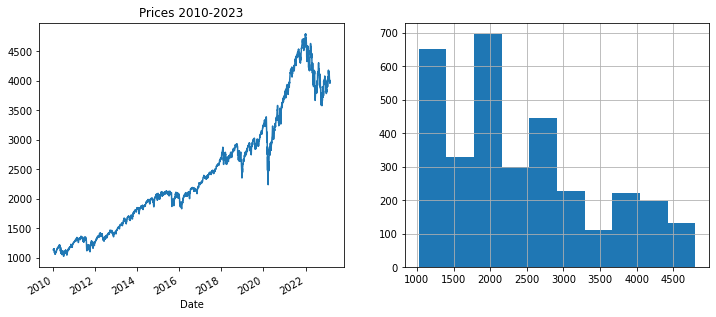

In [4]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(1,2, figsize=(12, 5))
data[year_from:]['Close'].plot(ax=axs[0], title = 'Prices {}-2023'.format(year_from))
data[year_from:]['Close'].hist(ax=axs[1]);

Si observamos el precio de cierre del SP500, vemos que sigue una tendencia ascendente, como la economía. Podríamos considerar el usarlo como variable objetivo, pero basta con examinar su histograma para descartarlo ya que no tiene buenas propiedades estadísticas.

Una alternativa tradicional de la literatura financiera consiste en el retorno como cambio porcentual o bien el logaritmo de los retornos, que tiene mejores propiedades estadísticas. Además, podríamos:

- Evaluar los momentos de mayores caídas y subidas.

- Conocer los percentiles para cada cambio % de precio.

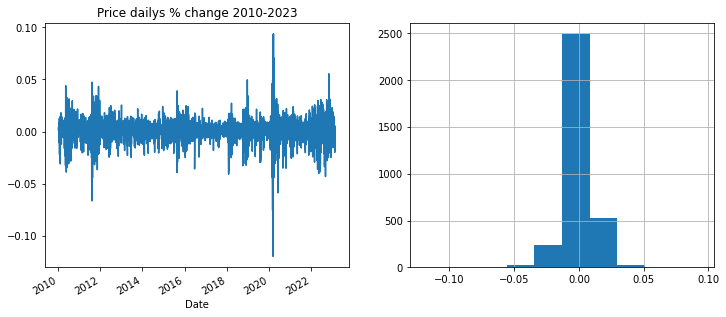

In [5]:
fig, axs = plt.subplots(1,2, figsize=(12, 5))
data.pct_change()[year_from:]['Close'].plot(ax=axs[0], title = 'Price dailys % change {}-2023'.format(year_from))
data.pct_change()[year_from:]['Close'].hist(ax=axs[1]);

Si ahora trasladásemos esta variable respuesta a la decisión, podríamos considerar como LONG cualquier log-retorno >0, y tomar nuestra decisión de entrada o salida del mercado con un horizonte H de antelación. No obstante, en el ámbito financiero no estamos considerando nuestra propensión o aversión al riesgo, y desde un punto de vista numérico dando la misma importancia a pequeñas y grandes caídas (o subidas) del precio. Además, se ha demostrado la dificultad a la hora de realizar previsiones puntuales de la variación o el log-retorno del precio.

Por estas razones, Lopez de Prado propone el uso de la triple barrera, que nos permite considerar, dentro de una misma etiqueta o variable respuesta, los siguientes conceptos:

- Un período de tiempo para que el precio siga el camino.
- Una máxima caída (drawdown) admisible.
- Un mínimo retorno a esperar en el período de tiempo seleccionado.

En nuestro caso, simplificaremos la triple barrera, para tener una respuesta binaria, con las siguientes consideraciones:

- 1 (LONG): el periodo de tiempo desde T el día siguiente a T+h, el horizonte de tiempo seleccionado, proporciona al menos un retorno r.
- 0 (OUT): desde T a T+h o bien no conseguimos el mínimo retorno esperado, o sufrimos un drawdown superior al admisible.

Si fijamos nuestro horizonte de decisión para los siguientes 7 días, podemos analizar tanto el retorno esperado como decidir, para esa trayectoria, el máximo drawdown admisible.

In [6]:
r = pd.DataFrame(1+data['Close'].pct_change()[year_from].dropna())
100*(r.rolling(7).agg(lambda x: x.prod()).describe()-1)

,Close
count,24400.000000
mean,0.324029
std,-97.155258
min,-7.410169
25%,-1.531446
50%,0.933886
75%,2.052799
max,7.098711


Viendo que el retorno esperado es del 0.94% (mediano) o 0.33% (promedio), podemos imponer una perspectiva algo más optimista para nuestra variable y exigir un mínimo del 1.5% semanal. Además, seremos neutrales al riesgo frente al instrumento original y admitiremos un drawdown puntual siempre menor al 7%. Calculamos entonces nuestra variable respuesta.

In [7]:
def below_dd(series, max_dd):
    return any((1-series)>max_dd)

def over_rt(series, min_rt):
    return any(series.cumprod() >= 1+min_rt)

def compute_triple_barrier(_, max_dd, min_rt, hz, label_type : str = None, debug_mode = False):
    """
    df: dataframe with the closing prices
    Based on Advances in Financial Machine Learning
    """
    _ = (1 + _.pct_change()).loc[:,['Close']]

    dd_flag = _.rolling(hz).agg(lambda x: below_dd(x, max_dd)).shift(-hz).rename(columns = {'Close':'drawdown'})
    rt_flag = _.rolling(hz).agg(lambda x: over_rt(x, min_rt)).shift(-hz).rename(columns = {'Close':'return'})

    _ = _.merge(dd_flag, right_index = True, left_index = True).merge(rt_flag, right_index= True, left_index = True)#.reset_index()
    
    
    if label_type == 'binary':
        _['label'] = 1*(_['return']==1)
    else:
        _['label'] = 1*(_['return']==1)-1*(_['drawdown']==1)
        
    
    if debug_mode:
        return _
    else:
        return _.loc[:,['label']]

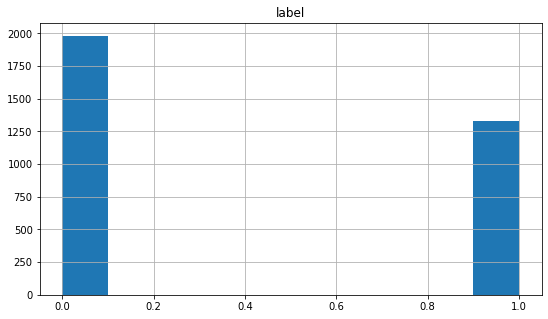

In [8]:
label = compute_triple_barrier(data[year_from:], 0.07, 0.015, 7, label_type = 'binary')
fig, ax = plt.subplots(1,1, figsize=(9, 5))
label.hist(ax=ax);

Aunque nuestro set de datos no está balanceado, teniendo el doble de momentos en los que estar OUT frente a LONG, procederemos a entrenar el modelo y consideraremos si es necesario ponderar las decisiones para evitar falsos positivos (decisiones de estar LONG cuando deberíamos estar OUT) o bien falsos negativos, que simbolizarían oportunidades perdidas de realizar un beneficio.

Es necesario conjugar ambas facetas, la financiera, con nuestras metas y aversión al riesgo, con la del Machine Learning, con las métricas de clasificación tradicionales como precision, recall, F1, etc. para evaluar el modelo no solo desde el punto de vista numérico, sino de nuestra decisión.

## Variables explicativas

Está fuera del alcance de este artículo entrar en profundidad en la generación de nuevas variables (feature engineering), por lo que usaremos un conjunto reducido de indicadores técnicos, para que nuestro modelo sea lo más simple posible, y con cada uno de ellos reflejando una de las facetas del instrumento SP500:

- RSI: relative strength index o índice de fuerza relativa, para medir el equilibrio entre los compradores y vendedores.
- Oscilador de Aroon: aroon oscillator para evaluar la continuidad de una tendencia o su ruptura.
- VIX: para monitorizar la volatilidad del mercado en general.
- MACD: otro indicador de momento para indicar puntos de compra o de venta. Haremos un postprocesado para convertirlo en una variable entera, siendo 1 cuando el MACD pase a estar por encima de la "señal" (EMA del MACD de 9 días), -1 cuando pase a estar bajo ella y 0 en cualquier otro caso.

In [9]:
import numpy as np 
import pandas as pd 
from typing import List

def rsi_point(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)
    
def rsi(df_ohlc, window:int = 14, norm:bool=False):
    mom_1d = (df_ohlc['Close'] - df_ohlc['Close'].shift(1)).fillna(0)
    return mom_1d.rolling(center=False, window=window).apply(rsi_point).fillna(0)/(100 if norm else 1)

def aroon(df, tf=25, indicator_only:bool=True):
    aroonup = []
    aroondown = []
    x = tf
    while x< len(df.index):
        aroon_up = ((df['High'][x-tf:x].tolist().index(max(df['High'][x-tf:x])))/float(tf))*100
        aroon_down = ((df['Low'][x-tf:x].tolist().index(min(df['Low'][x-tf:x])))/float(tf))*100
        aroonup.append(aroon_up)
        aroondown.append(aroon_down)
        x+=1

    if indicator_only:
        return pd.Series(np.array(aroonup) - np.array(aroondown), index = df.index[tf:])
    else:
        return pd.DataFrame({'aroon_up':aroonup, 'aroon_down':aroondown, 'aroon_oscillator':np.array(aroonup) - np.array(aroondown)}, index = df.index[tf:])

def macd(df, windows:List = [26, 12, 6], indicator_only:bool=True):
    L_ema = df['Close'].ewm(span=26, min_periods=0, adjust=True, ignore_na=False).mean()
    s_ema = df['Close'].ewm(span=12, min_periods=0, adjust=True, ignore_na=False).mean()
    MACD = s_ema - L_ema
    signal = MACD.ewm(span=9, min_periods=0, adjust=True, ignore_na=False).mean()
    flag = 1*(MACD < signal)
    if indicator_only:
        return -flag.diff()
    else:
        return pd.DataFrame({'MACD':MACD, 'signal':signal,'indicator':-flag.diff()})
        
def get_vix():
    #return pdr.get_data_yahoo("^VIX").loc[:,['Close']]
    return get_stock_prices(conn, "^VIX").loc[:,['Close']]


In [10]:
RSI = rsi(data)
AROON = aroon(data)
MACD = macd(data)
VIX = get_vix()

In [11]:
df_indicators = pd.DataFrame(RSI).rename(columns = {'Close':'rsi'}).merge(
    pd.DataFrame(AROON).rename(columns = {0:'aroon_oscillator'}), right_index = True, left_index = True).merge(
    pd.DataFrame(MACD).rename(columns = {'Close':'MACD_indicator'}), right_index =True, left_index =True).merge(
    pd.DataFrame(VIX).rename(columns = {'Close':'VIX'}), right_index = True, left_index = True)
df_indicators.tail()

,rsi,aroon_oscillator,MACD_indicator,VIX
Date,,,,
2023-02-23,45.183673,40.0,-0.0,21.14
2023-02-24,45.264000,40.0,-0.0,21.67
2023-02-27,42.036291,36.0,-0.0,20.95
2023-02-28,38.099661,-60.0,-0.0,20.70
2023-03-01,41.129768,-60.0,-0.0,20.77


## Backtesting

Es importante destacar que en el contexto financiero no nos sirve únicamente el enfoque tradicional de ciencia de datos / Machine Learning de dividir el dataset entre train y test, sino que es necesario garantizar:

Que no hay conocimiento del futuro implicado en la toma de decisiones: esto nos obliga a que nuestra validación deba tener, obligatoriamente, una fecha posterior a nuestro entrenamiento, incluso requiriendo un período de embargo entre ellas.

Que la trayectoria en el horizonte T a T+h se toma con datos disponibles en T-1.

Para nuestro backtesting, tomaremos una ventana de datos creciente desde el año 2010 hasta 2022, entrenando el modelo hasta T-1 y decidiendo para el mes siguiente. Podríamos hacer un backtesting continuo, pero ello implicaría entrenar un modelo para cada día del set de validación. Nosotros lo simplificaremos, imponiendo un conjunto de entrenamiento mínimo entre 2010 y 2015, ambos inclusive, y decidiendo a partir de enero de 2016.

## Métricas ML
- Matriz de confusión sobre cada mes de validación.
- Accuracy, precision, recall y F1 a nivel global.

No penalizaremos los falsos positivos y negativos de manera distinta, como se mencionó anteriormente.

## Métricas financieras
- Sharpe ratio.
- Retorno anualizado.
- Máximo drawdown.

Las métricas financieras las computaremos a nivel de la trayectoria seguida entre 2016 y 2022 y las compararemos con una posición a largo durante todo el periodo.

In [12]:
import pandas as pd
from typing import List
import numpy as np

def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())

                         
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    1: good, 2: very good, 3: excelent, attention!
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

                       
def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4
    
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})


def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    if isinstance(r, pd.Series):
        is_negative = r < 0
        return r[is_negative].std(ddof=0)
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(semideviation)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))



def summary_stats(r, riskfree_rate=0.03, ppy=12, keep_cols:List = None):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    if isinstance(r, pd.Series):
        r = pd.DataFrame(r)
        
    ann_r = r.aggregate(annualize_rets, periods_per_year=ppy)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=ppy)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=ppy)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    summary =  pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })
    if keep_cols:
        return summary.loc[:,keep_cols]
    else:
        return summary

## Procedimiento de backtesting
Anteriormente, hemos computado nuestra variable respuesta bajo unas condiciones de rentabilidad y un máximo drawdown admisible en un horizonte temporal de 7 días. Evaluar el modelo desde una perspectiva ML no reviste mayor complicación, ya que cada punto es independiente de los anteriores y del horizonte temporal que consideremos para la trayectoria posterior a la previsión. Éste no es el caso para las variables económicas.

Debemos considerar la trayectoria seguida por las decisiones del algoritmo ya que vamos a componer el interés a lo largo del período de análisis 2016-2022. Para ello, tomaremos las siguientes asunciones:

- Partimos con un portfolio inicial de 1000 US$.
- Rebalanceamos diariamente en función de las decisiones del modelo.
- El % del portfolio en el mercado, será la proporción de LONG sobre OUT que proporcione el modelo. Así, sobre un día arbitrario del periodo de test, pasan 7 trayectorias y por lo tanto 7 previsiones distintas. Si tuviésemos por ejemplo 5 LONG y 2 OUT, el % sería de 71.43%.
- Asumimos que no hay coste en las transacciones.

In [13]:
model_data = label.merge(df_indicators, right_index= True, left_index = True)
model_data.head()

,label,rsi,aroon_oscillator,MACD_indicator,VIX
Date,,,,,
2010-02-09,1,37.825028,-52.0,-0.0,26.00
2010-02-10,1,41.840973,-52.0,-0.0,25.40
2010-02-11,1,45.488492,-52.0,-0.0,23.96
2010-02-12,1,49.816143,-52.0,-0.0,22.73
2010-02-16,0,50.843855,-52.0,1.0,22.25


En primer lugar generaremos la señal del modelo, que será agnóstica a nuestros criterios de aversión al riesgo, rebalanceo, etc. y que será sobre la que computaremos las métricas Machine Learning. Ésta tomará valores entre el 0 (total confianza en estar OUT) u el 1 (análogo para LONG). Por defecto tomaremos cualquier valor igual o superior a 0.5 como 1, aunque también podríamos optimizar este criterio desde una perspectiva híbrida de Machine Learning y financiera para optar por minimizar falsos positivos (falsas entradas al mercado) o negativos (perder oportunidades de inversión).

In [14]:
def build_elasticnet():
    return ElasticNet()

def generate_signal(model_constructor, data, label:str, start_date:str, end_date:str, retrain_window:str="1m", keep_models:bool=False):
    # generate date series ---
    first = pd.to_datetime(start_date).replace(day=1)
    seriesFirstDate = first - datetime.timedelta(days=1)
    dates = pd.date_range(seriesFirstDate, end_date, freq = retrain_window)

    signal = []
    models = {}
    for idx in tqdm(range(1, len(dates))):
        # Define train and test ---
        subset = data.loc[data.index<=dates[idx],:]
        train = subset.loc[subset.index<=dates[idx-1],:]
        test = subset.loc[subset.index>dates[idx-1],:]
        X_train = train.loc[:,[i for i in train.columns if i != label]]
        y_train = train[label]
        # Instantiate and train new model ---
        model = model_constructor()
        model.fit(X_train.to_numpy(), y_train)
        # Generate signal ---
        _ = model.predict(test.loc[:,[i for i in test.columns if i != label]].to_numpy())
        signal.append(pd.DataFrame({'label':_}, index = test.index))
        if keep_models:
            models[f"{min(test.index).strftime('%Y_%m_%d')}_{max(test.index).strftime('%Y_%m_%d')}"] = model

    return pd.concat(signal), models

In [15]:
model_data

,label,rsi,aroon_oscillator,MACD_indicator,VIX
Date,,,,,
2010-02-09,1,37.825028,-52.0,-0.0,26.00
2010-02-10,1,41.840973,-52.0,-0.0,25.40
2010-02-11,1,45.488492,-52.0,-0.0,23.96
2010-02-12,1,49.816143,-52.0,-0.0,22.73
2010-02-16,0,50.843855,-52.0,1.0,22.25
...,...,...,...,...,...
2023-02-23,0,45.183673,40.0,-0.0,21.14
2023-02-24,0,45.264000,40.0,-0.0,21.67
2023-02-27,0,42.036291,36.0,-0.0,20.95


In [16]:
from datetime import date
signal, models = generate_signal(
    build_elasticnet,
    model_data,
    label = 'label',
    start_date = date(int(year_from)+1, 1, 1).strftime("%Y-%m-%d"),
    end_date = date.today().strftime("%Y-%m-%d"),
    keep_models = True
)

100%|██████████| 146/146 [00:00<00:00, 259.45it/s]


## Evaluación ML de los modelos generados
A continuación evaluaremos los 77 modelos generados, sobre la validación de 1 mes deslizante utilizando las métricas tradicionales de clasificación.
Consideraremos como LONG cualquier valor igual o superior a 0.5.

In [17]:
def Find_Optimal_Cutoff(y_real, y_hat):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    Original Source
    ---------------
    https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
    """
    fpr, tpr, threshold = roc_curve(y_real, y_hat)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

def create_cmatrix(y_real, y_hat, threshold):
    msg.info(f"Confusion matrix with {threshold if 0.5-threshold>1e-4 else ' default (0.5)'} threshold:")
    cm= confusion_matrix(y_real.values, y_hat.map(lambda x: 1 if x > threshold else 0).values, normalize='true')
    print(dict(zip(['tNr', 'fPr', 'fNr', 'tPr'], ['{:.2f}%'.format(100*i) for i in cm.reshape(-1)])))

def compute_metrics(y_real, y_hat):
    fpr, tpr, thresholds = roc_curve(y_real, y_hat, pos_label = 1)
    _auc = auc(fpr, tpr)
    msg.info("AUC:", _auc)
    op_th = Find_Optimal_Cutoff(y_real, y_hat)[0]
    msg.info("Optimal threshold:", op_th)
    create_cmatrix(y_real, y_hat, 0.5)
    create_cmatrix(y_real, y_hat, op_th)

In [18]:
df_labels = signal.merge(
    model_data.loc[:,'label'],
    how = 'inner',
    right_index = True,
    left_index = True,
    suffixes = ['_hat', '_real']
)
df_labels.tail(3)

,label_hat,label_real
Date,,
2023-02-24,0.419672,0
2023-02-27,0.416673,0
2023-02-28,0.526027,0


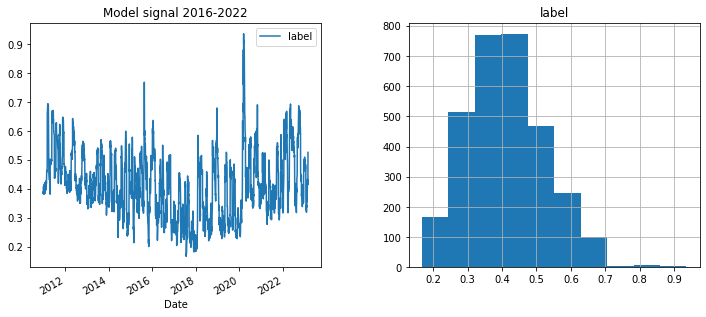

In [19]:
fig, axs = plt.subplots(1,2, figsize=(12, 5))
signal.plot(ax=axs[0], title = 'Model signal 2016-2022')
signal.hist(ax=axs[1]);

In [20]:
compute_metrics(df_labels.label_real, df_labels.label_hat)

ℹ AUC:
0.6831636227796426
ℹ Optimal threshold:
0.4111324298294674
ℹ Confusion matrix with  default (0.5) threshold:
{'tNr': '86.85%', 'fPr': '13.15%', 'fNr': '66.64%', 'tPr': '33.36%'}
ℹ Confusion matrix with 0.4111324298294674 threshold:
{'tNr': '63.91%', 'fPr': '36.09%', 'fNr': '36.17%', 'tPr': '63.83%'}


Nuestro modelo dista mucho de ser perfecto. Si tomamos la probabilidad del 50% por defecto, un 7.65% de nuestras entradas al mercado son fallidas. Por otra parte, perdemos hasta un 70% de las oportunidades de entrada al mercado, al tener una elevada tasa de falsos negativos. Optimizando el threshold, conseguimos errar en un tercio de los casos, tanto con entradas incorrectas como con pérdidas de oportunidades del mercado.

## Evaluación financiera

Ahora evaluaremos desde el punto de vista financiero los resultados del modelo, con dos configuraciones diferentes y comparándolas con una posición a largo en todo el horizonte 2016-2022.

- **Configuración 1:** considerar como LONG las probabilidades superiores al threshold, y usar como asignación monetaria el promedio. Así, si sobre el día D hay 7 previsiones y tenemos 4 OUT y 3 LONG, el % será 40+31 / 7 = 42.85.
- **Configuración 2:** considerar las probabilidades y obtener su media móvil de 7 días.
- **Referencia:** LONG en el periodo 2016-2022.
- **Ppy:** 253

In [21]:
threshold = 0.5
opt_threshold = Find_Optimal_Cutoff(df_labels.label_real, df_labels.label_hat)[0]

signal['config_1_default'] = signal['label'].map(lambda x: 1 if x> threshold else 0)
signal['config_1_opt'] = signal['label'].map(lambda x: 1 if x> opt_threshold else 0)
signal['config_2'] = signal['label']
signal['baseline'] = 1.0
signal.head()

,label,config_1_default,config_1_opt,config_2,baseline
Date,,,,,
2011-01-03,0.405931,0,0,0.405931,1.0
2011-01-04,0.383008,0,0,0.383008,1.0
2011-01-05,0.390649,0,0,0.390649,1.0
2011-01-06,0.383008,0,0,0.383008,1.0
2011-01-07,0.383008,0,0,0.383008,1.0


In [22]:
configs = signal.rolling(7).mean().dropna()
configs.tail()

,label,config_1_default,config_1_opt,config_2,baseline
Date,,,,,
2023-02-22,0.392861,0.000000,0.285714,0.392861,1.0
2023-02-23,0.399411,0.000000,0.428571,0.399411,1.0
2023-02-24,0.407610,0.000000,0.571429,0.407610,1.0
2023-02-27,0.416414,0.000000,0.714286,0.416414,1.0
2023-02-28,0.433889,0.142857,0.857143,0.433889,1.0


In [23]:
results = data.pct_change().loc[:,['Close']].merge(configs, right_index = True, left_index = True, how = 'inner')
for i in configs.columns:
    results[i] = results[i]*results['Close']
config_cols = ['baseline']+[i for i in results.columns if i.startswith('config')]
results = results.loc[:,config_cols]

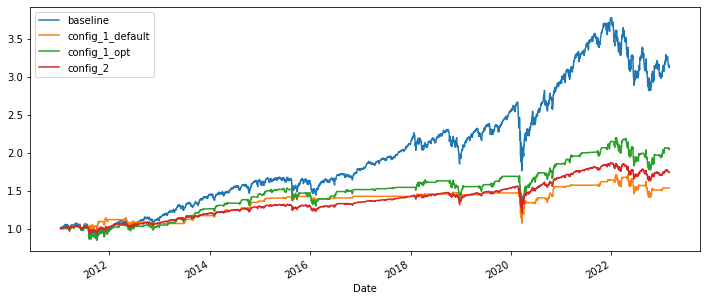

In [24]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))
(1+results).cumprod().plot(ax=ax);

In [25]:
summary = []
for c in config_cols:
    summary.append(summary_stats(results[c], riskfree_rate=0.00, ppy=253))
pd.concat(summary)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
baseline,0.099076,0.178232,-0.516108,16.015306,0.016637,0.027508,0.555881,-0.339250
config_1_default,0.036199,0.123737,-0.544556,56.820299,0.005335,0.018850,0.292550,-0.285203
config_1_opt,0.061175,0.150766,-0.511614,28.845249,0.011697,0.024245,0.405758,-0.285203
config_2,0.047026,0.098064,-0.200204,45.341588,0.005017,0.014566,0.479547,-0.225270


## Resultados
De todas las configuraciones posibles, ninguna proporciona mejores resultados que asumir una posición a largo en el instrumento para todo el periodo. No obstante, todas permiten reducir el máximo drawdown entre un 5 y un 11% hasta -28.5% y -22.2%, respectivamente. Y la configuración 2 proporciona un ratio de Sharpe de 0.5, cercano al 0.67 de la posición a largo.

No obstante, la conclusión es que el modelo resulta demasiado averso al riesgo lo que se traduce en un coste oportunidad de entre el 5 y el 7% anual por no participar en el mercado.

## Explicabilidad
Por último, no solo es importante la calidad de nuestra toma de decisiones, sino también el poder aducir cuál ha sido el driver determinante para decidir posicionarnos en el mercado (LONG) o bien fuera del mercado (OUT).

Para ello, existen numerosos enfoques disponibles y sus correspondientes librerías, pero hemos seleccionado SHAP al ser agnóstica al modelo y por lo tanto, más flexible de cara a futuros artículos donde evaluemos distintas familias algorítmicas.

In [26]:
random_model = np.random.choice(list(models.keys()))
random_model

'2011_06_01_2011_06_30'

In [27]:
f = lambda x: models[random_model].predict(x)
med = model_data.loc[:,[i for i in model_data.columns if i!='label']].median().values.reshape((1,model_data.shape[1]-1))
explainer = shap.Explainer(f, med)
shap_values = explainer(model_data.loc[str(int(year_from)+1),[i for i in model_data.columns if i!='label']])

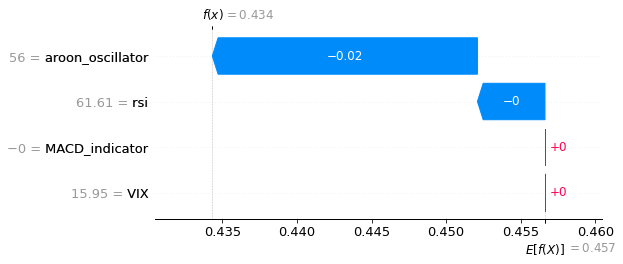

In [28]:
shap.plots.waterfall(shap_values[129])

En el ejemplo seleccionado, vemos como respecto a la probabilidad esperada del 33.5%, el oscilador de Aroon aumenta la probabilidad de LONG en un 11% y el RSI en un 2%, que se ve mitigado en un 3% por el valor del VIX. Este tipo de análisis son útiles de cada a analizar ex-ante si alguna de las variables sobre las que se apoya nuestra decisión está siendo determinante o todas están definiendo la coyuntura de manera equiponderada, y ex-post para analizar qué llevo al modelo a decidir si permanecer OUT o posicionarse LONG en el mercado.

## Conclusiones

- Usar el Machine Learning en el ámbito financiero nos sirve para considerar múltiples variables en el proceso de toma de decisiones.
- El modelo lineal Elastic Net resulta insuficiente para capturar el la coyuntura que nos proporcionan del mercado las variables explicativas seleccionadas.
- En nuestro caso de uso, es mejor una posición a LARGO sin rebalanceos que usar el modelo de ML para las decisiones.
- El uso de técnicas como SHAP nos permite no solo evaluar la calidad de nuestras decisiones, sino también qué variable o variables tuvieron mayor peso en ella.

## Información de sesión

In [29]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.5.2
numpy               1.23.2
pandas              1.4.3
scipy               1.9.1
session_info        1.0.0
shap                0.41.0
sklearn             1.1.1
tqdm                4.64.0
wasabi              NA
-----
IPython             8.4.0
jupyter_client      7.3.4
jupyter_core        4.10.0
notebook            6.4.12
-----
Python 3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]
Windows-10-10.0.19045-SP0
-----
Session information updated at 2023-03-01 13:38
